In [4]:
import sys
# sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Applications/PyCharm.app/Contents/plugins/python/helpers-pro/jupyter_debug', '/Applications/PyCharm.app/Contents/plugins/python/helpers/pydev', '/Users/david/Documents/mastersCode/ubm/gmm_ubm', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [5]:
# test for gmm-ubm on whale calls
from importlib import reload
import audio_datastore.audio_datastore as myads
reload(myads)
import os.path
from collections import Counter
import random
from python_speech_features import mfcc
import scipy.io.wavfile as wav
from spafe.utils import vis
import matplotlib.pyplot as plt
import misc.vad as vad
from sklearn.mixture import GaussianMixture, _gaussian_mixture
reload(vad)
import numpy as np
import librosa.feature as fe
reload(fe)
import librosa.util.utils as librosa_utils
import whale.setup.constants as const
from scipy.special import logsumexp

In [6]:
# helper functions

# [2] feature extraction
# 	• Normalize the audio
# 	• Use detectSpeech to remove nonspeech regions from the audio
# 	• Extract features from the audio
# 	• Normalize the features
#   * Apply cepstral mean normalization

eps = np.finfo(np.float64).eps

def helper_feature_extraction(raw_audio_file, norm = None):
    # read in file
    (signal_rate, signal) = wav.read(raw_audio_file)

    # normalise
    signal = librosa_utils.normalize(signal)

    # detect / vad, not working currently

    # fe
    mfcc_feats = fe.mfcc(y=signal,sr=const.SAMPLING_RATE, n_mfcc=13, n_fft=1024).T

    # feature normalisation and Cepstral mean subtraction (for channel noise)
    if norm:
        mfcc_feats = (mfcc_feats - norm.means) / norm.std
        mfcc_feats = mfcc_feats - np.mean(mfcc_feats)
        return mfcc_feats
    else:
        return mfcc_feats

In [7]:
# 27 files in total
# test = 5
# enrol = 8
# train = 15

datasetFolder = r"/Users/david/Documents/mastersCode/ubm/whale/setup/data_spliced"
ads = myads.AudioDatastore()
ads.populate(datasetFolder,include_sub_folders=True, label_source=True)
Counter(ads.labels).values()
adsTest, adsTrain = myads.split(ads, 5)
adsEnroll, adsTrain = myads.split(adsTrain, 8)
adsTrain, _ = myads.split(adsTrain, 15)
adsNorm, _ = myads.split(ads, 27)

In [8]:
# extract all features and use to get feature normalization
all_features = []
for file in adsNorm.files:
    feature = helper_feature_extraction(file)
    all_features.append(feature)

In [9]:
def get_norm_factors(all_f):
    means = []
    std = []
    for f in all_f:
        means.append(np.mean(f, axis=0))
        std.append(np.std(f, axis=0))

    means = np.array(means)
    means = np.mean(means, axis=0)

    std = np.array(std)
    std = np.mean(std, axis=0)

    class NormFactor:
        def __init__(self, m, s):
            self.means = m
            self.std = s

    return NormFactor(means, std)

In [10]:
# collect normalization factors
import pickle
# import helper_functions

normFactors = get_norm_factors(all_features)

In [11]:
train_features = []
for i in range(len(adsTrain.files)):
    train_feature = helper_feature_extraction(adsTrain.files[i], normFactors)
    train_features.append(train_feature)

In [12]:
ubm = GaussianMixture(n_components=32, covariance_type='diag')
train_features_flattened = np.array([item for sublist in train_features for item in sublist])
ubm.fit(train_features_flattened)
print('sklearn model' + str(ubm.score(train_features[0])))

sklearn model-15.133091264287247


In [13]:
# ENROLL

# [4] map enroll
import helper_functions as hf

# do stuff
numComponents = 32
numFeatures = 13
relevanceFactor = 16
speakers = np.unique(adsEnroll.labels)
numSpeakers = len(speakers)
gmmCellArray = []

for i in range(len(speakers)):
    adsTrainSubset = myads.subset(adsEnroll, speakers[i])
    N = np.zeros((1, numComponents))
    F = np.zeros((numFeatures, numComponents))
    S = np.zeros((numFeatures, numComponents))

    for file in adsTrainSubset.files:
        speaker_feature = helper_feature_extraction(file, normFactors)
        if len(speaker_feature) > 0:
            # BW stats, # TODO make this in to function
            n,f,s,l = hf.helper_expectation(speaker_feature, ubm)
            N = N + n
            F = F + f
            S = S + s
        else:
            print('skipping train file because len = 0')

    gmm = hf.helper_maximization(N,F,S,numComponents)

    alpha = N / (N + relevanceFactor)

    mu = (alpha.T*gmm.means_) + ((1-alpha).T*ubm.means_)
    gmm.means_ = mu

    sigma = alpha*(S/N) + (1-alpha)*(ubm.covariances_.T + np.square(ubm.means_).T) - np.square(gmm.means_).T
    sigma = np.maximum(sigma, eps).T
    gmm.covariances_ = sigma

    gmm.precisions_cholesky_ = _gaussian_mixture._compute_precision_cholesky(gmm.covariances_, 'diag')

    weights = alpha*(N/np.sum(N)) + (1-alpha)*ubm.weights_.T
    weights = np.squeeze(weights/np.sum(weights))
    gmm.weights_ = weights

    gmmCellArray.append(gmm)

print('speaker enrollment complete')


speaker enrollment complete


In [14]:
adsTrainSubset = myads.subset(adsEnroll, speakers[0])
speaker_feature = helper_feature_extraction(adsTrainSubset.files[1], normFactors)
adapted_score = gmmCellArray[0].score(speaker_feature)
ubm_score = ubm.score(speaker_feature)
print(adapted_score, ubm_score)

-18.95687669208021 -21.43734392015952


In [15]:
enrolled_gmms = {}
for i in range(len(gmmCellArray)):
    enrolled_gmms[speakers[i]] = gmmCellArray[i]

In [16]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [17]:
# false rejection rate -
# The speaker false rejection rate (FRR) is the rate that a given speaker is incorrectly rejected. Use the known speaker set to determine the speaker false rejection rate for a set of thresholds.

llr = []

for i in range(len(speakers)):
    cur_speaker = speakers[i]
    local_gmm = enrolled_gmms[cur_speaker]
    adsTestSubset = myads.subset(adsTest, cur_speaker)
    llrPerSpeaker = np.zeros(len(adsTestSubset.files))

    for y in range(len(adsTestSubset.files)):
        file = adsTestSubset.files[y]
        speaker_feature = helper_feature_extraction(file, normFactors)

        if len(speaker_feature) > 0:

            logLikelihood = local_gmm._estimate_weighted_log_prob(speaker_feature)
            lspeaker = logsumexp(logLikelihood, axis=1)

            logLikelihood = ubm._estimate_weighted_log_prob(speaker_feature)
            lubm = logsumexp(logLikelihood, axis=1)

            llrPerSpeaker[y] = np.mean(running_mean(lspeaker-lubm, 3))

    llr.append(llrPerSpeaker)

In [18]:
llr_cat = np.concatenate(llr, axis=0)
thresholds = np.arange(-0.5,2.5,0.01)
thresholds = np.expand_dims(thresholds, axis=1)
ones = np.ones((1, len(llr_cat)))
thresholds = thresholds * ones
frr = np.mean((llr_cat < thresholds), axis=1)

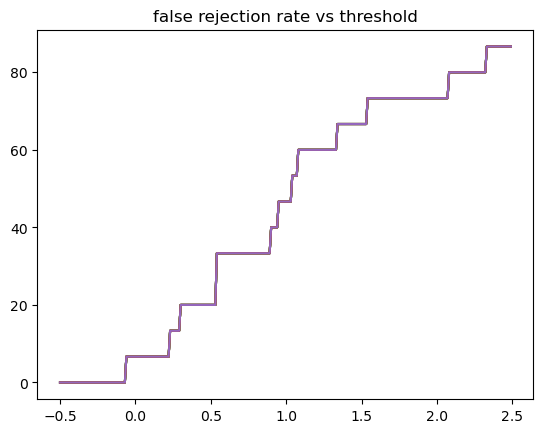

In [19]:
import matplotlib.pyplot as plt

plt.plot(thresholds, frr * 100)
plt.title('false rejection rate vs threshold')
plt.show()

In [29]:
# confusion matrix

# false rejection rate -
# The speaker false rejection rate (FRR) is the rate that a given speaker is incorrectly rejected. Use the known speaker set to determine the speaker false rejection rate for a set of thresholds.

all_whales = []
for i in range(len(speakers)):
    whale_model = enrolled_gmms[speakers[i]]
    cur_whale = []

    # loop through data
    for y in range(len(speakers)):
        dataSubset = myads.subset(adsTest, speakers[y])
        data_ll = []

        for z in range(len(dataSubset.files)):
            file = dataSubset.files[z]
            whale_feature = helper_feature_extraction(file, normFactors)

            logLikelihood = whale_model._estimate_weighted_log_prob(whale_feature)
            lspeaker = logsumexp(logLikelihood, axis=1)

            logLikelihood = ubm._estimate_weighted_log_prob(whale_feature)
            lubm = logsumexp(logLikelihood, axis=1)

            data_ll.append(np.mean(running_mean(lspeaker-lubm, 3)))

        cur_whale.append(np.mean(data_ll))

    all_whales.append(cur_whale)

np.array(all_whales) # is this working?

array([[ 0.85938588, -0.32007101, -0.59410135],
       [-0.40123801,  5.29921182, -0.40368823],
       [-0.61298323, -0.19562526,  1.16089304]])